<a href="https://colab.research.google.com/github/IzzyBrand/robotBottleFlip/blob/main/new_flip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lots of imports

In [ ]:
import meshcat.geometry as g
import numpy as np
import ipywidgets
import pydot
import os
from IPython.display import display, SVG

import importlib
import sys
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='master', drake_version='20201120', drake_build='nightly')

if 'google.colab' in sys.modules and os.getenv("DISPLAY") is None:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

# Use pyngrok on colab.
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

import pydrake.all
from manipulation.scenarios import AddIiwa, AddWsg, AddRgbdSensors, AddShape
from manipulation.utils import FindResource

from pydrake.all import (
    AddMultibodyPlantSceneGraph, ConnectMeshcatVisualizer, DiagramBuilder, 
    FindResourceOrThrow, GenerateHtml, InverseDynamicsController, 
    MultibodyPlant, Parser, Simulator, TrajectorySource)

from pydrake.all import (
    DiagramBuilder,
    RenderEngineVtkParams, MakeRenderEngineVtk, DepthCameraProperties, RgbdSensor, RigidTransform, RollPitchYaw,
    ColorRenderCamera, DepthRenderCamera, CameraInfo, ClippingRange, RenderCameraCore, DepthRange
)
    
from pydrake.all import RigidTransform, RotationMatrix, SpatialVelocity, PiecewisePolynomial

from pydrake.all import eq, MathematicalProgram, Solve

from pydrake.all import RenderEngineVtkParams, DepthCameraProperties, ModelInstanceIndex, DepthImageToPointCloud, BaseField, LeafSystem, AbstractValue

from google.colab.patches import cv2_imshow

def AddRgbdSensors(builder,
                   plant,
                   scene_graph,
                   also_add_point_clouds=True,
                   model_instance_prefix="camera",
                   properties=None,
                   renderer=None,
                   XC=RigidTransform()):
    """
    Adds a RgbdSensor to every body in the plant with a name starting with
    body_prefix.  If camera_info is None, then a default camera info will be
    used.  If renderer is None, then we will assume the name 'my_renderer', and
    create a VTK renderer if a renderer of that name doesn't exist.
    """
    if not renderer:
        renderer = "my_renderer"

    if not scene_graph.HasRenderer(renderer):
        scene_graph.AddRenderer(renderer,
                                MakeRenderEngineVtk(RenderEngineVtkParams()))

    if not properties:
        properties = DepthCameraProperties(width=640,
                                           height=480,
                                           fov_y=np.pi / 4.0,
                                           renderer_name=renderer,
                                           z_near=0.1,
                                           z_far=10.0)

    for index in range(plant.num_model_instances()):
        model_instance_index = ModelInstanceIndex(index)
        model_name = plant.GetModelInstanceName(model_instance_index)

        if model_name.startswith("iiwa"):
            iiwa_instance_index = ModelInstanceIndex(index)

    for index in range(plant.num_model_instances()):
        model_instance_index = ModelInstanceIndex(index)
        model_name = plant.GetModelInstanceName(model_instance_index)

        if model_name.startswith(model_instance_prefix):
            #body_index = plant.GetBodyIndices(model_instance_index)[0]
            body_index = plant.GetBodyIndices(iiwa_instance_index)[-1]
            print(plant.GetBodyFrameIdIfExists(body_index))
            print(plant.GetFrameByName("iiwa_link_7"))
            print(body_index)
            #print(plant.GetFrameByName("iiwa_link_7").index())
            rgbd = builder.AddSystem(
                #RgbdSensor(parent_id=plant.GetBodyFrameIdOrThrow(plant.GetFrameByName("iiwa_link_7").index),
                RgbdSensor(parent_id=plant.GetBodyFrameIdOrThrow(body_index),
                #RgbdSensor(parent_id=plant.GetFrameByName("iiwa_link_7").FrameIndex,
                           X_PB=XC,
                           properties=properties,
                           show_window=False))
            rgbd.set_name(model_name)

            builder.Connect(scene_graph.get_query_output_port(),
                            rgbd.query_object_input_port())

            # Export the camera outputs
            builder.ExportOutput(rgbd.color_image_output_port(),
                                 f"{model_name}_rgb_image")
            builder.ExportOutput(rgbd.depth_image_32F_output_port(),
                                 f"{model_name}_depth_image")
            builder.ExportOutput(rgbd.label_image_output_port(),
                                 f"{model_name}_label_image")

            if also_add_point_clouds:
                # Add a system to convert the camera output into a point cloud
                to_point_cloud = builder.AddSystem(
                    DepthImageToPointCloud(camera_info=rgbd.depth_camera_info(),
                                           fields=BaseField.kXYZs
                                           | BaseField.kRGBs))
                builder.Connect(rgbd.depth_image_32F_output_port(),
                                to_point_cloud.depth_image_input_port())
                builder.Connect(rgbd.color_image_output_port(),
                                to_point_cloud.color_image_input_port())

                class ExtractBodyPose(LeafSystem):

                    def __init__(self, body_index):
                        LeafSystem.__init__(self)
                        self.body_index = body_index
                        self.DeclareAbstractInputPort(
                            "poses",
                            plant.get_body_poses_output_port().Allocate())
                        self.DeclareAbstractOutputPort(
                            "pose",
                            lambda: AbstractValue.Make(XC),
                            self.CalcOutput)

                    def CalcOutput(self, context, output):
                        poses = self.EvalAbstractInput(context, 0).get_value()
                        pose = poses[int(self.body_index)]
                        output.get_mutable_value().set(pose.rotation(),
                                                       pose.translation())

                camera_pose = builder.AddSystem(ExtractBodyPose(body_index))
                builder.Connect(plant.get_body_poses_output_port(),
                                camera_pose.get_input_port())
                builder.Connect(camera_pose.get_output_port(),
                                to_point_cloud.GetInputPort("camera_pose"))

                # Export the point cloud output.
                builder.ExportOutput(to_point_cloud.point_cloud_output_port(),
                                     f"{model_name}_point_cloud")

Upload a model of the bottle from github. Uses requests to pull the raw SDF from github. Optionally we can upload the bottle manually.

In [ ]:
# from google.colab import files
# print('Please upload bottle.sdf')
# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# bottle_sdf = uploaded['bottle.sdf'].decode("utf-8")

import requests
resp = requests.get("https://raw.githubusercontent.com/IzzyBrand/robotBottleFlip/main/models/bottle.sdf")
if resp.status_code == 200:
    bottle_sdf = resp.text

### Set up the Manipulation Station

In [ ]:
def MakeManipulationStation(time_step=0.001, X_GC=RigidTransform(RotationMatrix.MakeZRotation(-np.pi/2), np.array([0.0, 0.0, 0.25]))):
    builder = pydrake.systems.framework.DiagramBuilder()

    # Add the iiwa, WSG, and cameras to the scene.
    plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(
        builder, time_step=time_step)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa)
    pydrake.multibody.parsing.Parser(plant).AddModelFromFile(
        FindResource("models/camera_box.sdf"), "camera0")
    pydrake.multibody.parsing.Parser(plant).AddModelFromString(bottle_sdf, 'sdf')

    # add platforms for the bottle to sit
    AddShape(plant, pydrake.geometry.Box(0.2, 0.2, 0.01), 'target_platform')
    AddShape(plant, pydrake.geometry.Box(0.2, 0.2, 0.01), 'initial_platform')
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("target_platform"),
                     RigidTransform(RotationMatrix(), [2.5,0,-.005]))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("initial_platform"),
                     RigidTransform(RotationMatrix(), [0.5,0,-.005]))

    plant.SetDefaultFreeBodyPose(plant.GetBodyByName('bottle_base_link'),
                          RigidTransform(RotationMatrix(), [0.5,0,0]))

    plant.Finalize()

    num_iiwa_positions = plant.num_positions(iiwa)

    # I need a PassThrough system so that I can export the input port.
    iiwa_position = builder.AddSystem(pydrake.systems.primitives.PassThrough(num_iiwa_positions))
    builder.ExportInput(iiwa_position.get_input_port(), "iiwa_position")
    builder.ExportOutput(iiwa_position.get_output_port(), "iiwa_position_command")

    # Export the iiwa "state" outputs.
    demux = builder.AddSystem(pydrake.systems.primitives.Demultiplexer(
        2 * num_iiwa_positions, num_iiwa_positions))
    builder.Connect(plant.get_state_output_port(iiwa), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), "iiwa_position_measured")
    builder.ExportOutput(demux.get_output_port(1), "iiwa_velocity_estimated")
    builder.ExportOutput(plant.get_state_output_port(iiwa), "iiwa_state_estimated")

    # Make the plant for the iiwa controller to use.
    controller_plant = pydrake.multibody.plant.MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant)
    AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()

    # Add the iiwa controller
    iiwa_controller = builder.AddSystem(
        pydrake.systems.controllers.InverseDynamicsController(
            controller_plant,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=False))
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_estimated_state())

    # Add in the feed-forward torque
    adder = builder.AddSystem(pydrake.systems.primitives.Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller.get_output_port_control(),
                    adder.get_input_port(0))
    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough = builder.AddSystem(
        pydrake.systems.primitives.PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough.get_output_port(), adder.get_input_port(1))
    builder.ExportInput(torque_passthrough.get_input_port(), "iiwa_feedforward_torque")
    builder.Connect(adder.get_output_port(), plant.get_actuation_input_port(iiwa))

    # Add discrete derivative to command velocities.
    desired_state_from_position = builder.AddSystem(
        pydrake.systems.primitives.StateInterpolatorWithDiscreteDerivative(
            num_iiwa_positions, time_step, suppress_initial_transient=True))
    desired_state_from_position.set_name("desired_state_from_position")
    builder.Connect(desired_state_from_position.get_output_port(),      
                    iiwa_controller.get_input_port_desired_state())
    builder.Connect(iiwa_position.get_output_port(), desired_state_from_position.get_input_port())

    # Export commanded torques.
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_commanded")
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_measured")

    # Wsg controller.
    wsg_controller = builder.AddSystem(pydrake.manipulation.schunk_wsg.SchunkWsgPositionController())
    wsg_controller.set_name("wsg_controller")
    builder.Connect(wsg_controller.get_generalized_force_output_port(),             
                    plant.get_actuation_input_port(wsg))
    builder.Connect(plant.get_state_output_port(wsg), wsg_controller.get_state_input_port())
    builder.ExportInput(wsg_controller.get_desired_position_input_port(), "wsg_position")
    builder.ExportInput(wsg_controller.get_force_limit_input_port(), "wsg_force_limit")
    wsg_mbp_state_to_wsg_state = builder.AddSystem(
        pydrake.manipulation.schunk_wsg.MakeMultibodyStateToWsgStateSystem())
    builder.Connect(plant.get_state_output_port(wsg), wsg_mbp_state_to_wsg_state.get_input_port())
    builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(), "wsg_state_measured")
    builder.ExportOutput(wsg_controller.get_grip_force_output_port(), "wsg_force_measured")

    # Cameras.
    #color_camera = ColorRenderCamera(
    #RenderCameraCore("manip_station_renderer", CameraInfo(1080, 720, np.pi/4),
    #             ClippingRange(0.1, 10.0), RigidTransform()), False)
    
    #depth_camera = DepthRenderCamera(color_camera.core(), DepthRange(0.1, 9.5))

    #XC = RigidTransform(
    #                   RollPitchYaw(0, np.pi, -np.pi/2.0),
    #                   [0, 0, .8])

    AddRgbdSensors(builder, plant, scene_graph, XC = X_GC)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "geometry_query")
    builder.ExportOutput(plant.get_contact_results_output_port(), "contact_results")
    builder.ExportOutput(plant.get_state_output_port(), "plant_continuous_state")

    return builder.Build()


## Set up an IK solver to easily position the end effector

inspired by [this notebook](https://colab.research.google.com/drive/1lDnpQ_zIaHGXKPUVk0bY5P9pOLMan5zd#scrollTo=WfPONFgTfuh9)

In [ ]:
class IKSolver(object):
    def __init__(self):
        ## setup controller plant
        self.plant = pydrake.multibody.plant.MultibodyPlant(0.0)
        iiwa = AddIiwa(self.plant)

        # Define frames
        self.world_frame = self.plant.world_frame()
        self.l7_frame = self.plant.GetFrameByName("iiwa_link_7")
        # gripper in link 7 frame (see source of AddWsg)
        self.X_L7G = RigidTransform(RollPitchYaw(np.pi / 2.0, 0, np.pi / 2.0), [0, 0, 0.114])

        # finalize the plant
        self.plant.Finalize()
        self.plant_context = self.plant.CreateDefaultContext()

    def solve(self, X_WT, q_guess = None, theta_bound=0.01, position_bound=0.01):
        """
        plant: a mini plant only consists of iiwa arm with no gripper attached
        X_WT: transform of target frame in world frame
        q_guess: a guess on the joint state sol
        """
        if q_guess is None:
            q_guess = np.zeros(7)
        
        ik_instance = pydrake.multibody.inverse_kinematics.InverseKinematics(self.plant)
        # align frame A to frame B
        ik_instance.AddOrientationConstraint(frameAbar=self.l7_frame, 
                                        R_AbarA=self.X_L7G.rotation(),
                                        #   R_AbarA=RotationMatrix(), # for link 7
                                        frameBbar=self.world_frame, 
                                        R_BbarB=X_WT.rotation(), 
                                        theta_bound=position_bound)
        # align point Q in frame B to the bounding box in frame A
        ik_instance.AddPositionConstraint(frameB=self.l7_frame, 
                                        p_BQ=self.X_L7G.translation(),
                                        # p_BQ=[0,0,0], # for link 7
                                    frameA=self.world_frame, 
                                    p_AQ_lower=X_WT.translation()-position_bound, 
                                    p_AQ_upper=X_WT.translation()+position_bound)
        prog = ik_instance.prog()
        prog.SetInitialGuess(ik_instance.q(), q_guess)
        result = Solve(prog)
        if not result.is_success():
            return result.GetSolution(ik_instance.q()), False
        return result.GetSolution(ik_instance.q()), True

## Create a top-level builder and add Meshcat + Station


In [ ]:
# create a new builder and attach the station as a child
X_GC = RigidTransform(RotationMatrix.MakeZRotation(-np.pi/2), np.array([0.0, 0.0, 0.25]))

builder = pydrake.systems.framework.DiagramBuilder()
station_diagram = builder.AddSystem(MakeManipulationStation(X_GC=X_GC))
station_diagram.set_name('station')
station_context = station_diagram.CreateDefaultContext()

# pull out the plant and the bottle for easy access
plant = station_diagram.GetSubsystemByName('plant')
plant_context = plant.CreateDefaultContext()
bottle = plant.GetBodyByName('bottle_base_link')

In [51]:
# the origin of the bottle is at the base of the bottle. The spout begins at
# 15.5cm and ends at 19cm in Z
X_GO_pregrasp = RigidTransform(RotationMatrix.MakeXRotation(np.pi/2.0).multiply(
        RotationMatrix.MakeZRotation(np.pi/2.0)), [0, 0.50, 0])
X_GO_grasp = RigidTransform(RotationMatrix.MakeXRotation(np.pi/2.0).multiply(
        RotationMatrix.MakeZRotation(np.pi/2.0)), [0.0, 0.30, 0.0])

# get the pose of the bottle and combine to compute a grasp pose
X_WO = bottle.EvalPoseInWorld(plant_context)
X_WG_grasp = X_WO.multiply(X_GO_grasp.inverse())
X_WG_pregrasp = X_WO.multiply(X_GO_pregrasp.inverse())
X_WC = X_WG_pregrasp.multiply(X_GC)

# Do ik to find the correct pose for the gripper
ik_solver = IKSolver()
q_init = station_diagram.GetOutputPort("iiwa_position_measured").Eval(station_context)
q_grasp, optimal = ik_solver.solve(X_WG_grasp, q_init)
q_pregrasp, optimal = ik_solver.solve(X_WG_pregrasp, q_init)

# create trajectories for the joints and the grippers
states = ['start', 'pregrasp', 'grasp', 'grasp_close', 'post_grasp']
times = np.array([0, 1, 1.5, 4, 19.5])[:,None]
grippers = np.array([[0, 0.1, 0.1, 0, 0]])
joints = np.array([q_init, q_pregrasp, q_grasp, q_grasp, q_pregrasp])

# attach a gripper controller. we need to wire the gripper controller output
# ports to the station input ports, so we can't just abstract this entirely into
# its own function like we could with creating the station diagram
traj_wsg_command = PiecewisePolynomial.FirstOrderHold(times, grippers)
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
wsg_source.set_name("wsg_command")
builder.Connect(wsg_source.get_output_port(), station_diagram.GetInputPort("wsg_position"))


# and attach the iiwa joint position controller similarly`
traj_iiwa_command = PiecewisePolynomial.FirstOrderHold(times, joints.T)
iiwa_source = builder.AddSystem(TrajectorySource(traj_iiwa_command))
iiwa_source.set_name("iiwa_command")
builder.Connect(iiwa_source.get_output_port(), station_diagram.GetInputPort("iiwa_position"))

[2020-12-09 23:52:16.624] [console] [warning] Currently MultibodyPlant does not handle joint limits for continuous models. However some joints do specify limits. Consider setting a non-zero time step in the MultibodyPlant constructor; this will put MultibodyPlant in discrete-time mode, which does support joint limits.
[2020-12-09 23:52:16.626] [console] [warning] Joints that specify limits are: `iiwa_joint_1`, `iiwa_joint_2`, `iiwa_joint_3`, `iiwa_joint_4`, `iiwa_joint_5`, `iiwa_joint_6`, `iiwa_joint_7`.


## Build the top-level builder and attach a simulator

In [ ]:
# connect a meshcat visualizer
meshcat = ConnectMeshcatVisualizer(builder,
                                   output_port=station_diagram.GetOutputPort("geometry_query"),
                                   zmq_url=zmq_url)

# not sure what this does
diagram = builder.Build()
context = diagram.CreateDefaultContext()

# get the context
# context = diagram.CreateDefaultContext()
# create a simulator
simulator = Simulator(diagram)


# NOTE(izzy): i couldn't create the plant_context in the same way as the diagram
# context if I wanted to be able to set the pose of the bottle... Not at all
# sure why.
# NOTE(izzy): these initial conditions were found using the optimization
# procedure a few cells below. not sure why they aren't really working...
mutable_context = diagram.GetMyContextFromRoot(simulator.get_mutable_context())
mutable_station_context = station_diagram.GetMyMutableContextFromRoot(mutable_context)

#mutable_context = diagram.GetMyContextFromRoot(simulator.get_mutable_context())

# set the position of the arm to the result of the IK above
# diagram.GetSubsystemByName('station').GetInputPort('iiwa_position').FixValue(mutable_station_context, q_goal)

# Note(chris I believe this is how we access the rbg / depth images)
meshcat.load(meshcat.GetMyContextFromRoot(context))
color_image = station_diagram.GetOutputPort("camera0_rgb_image").Eval(mutable_station_context)
pcl_drake = station_diagram.GetOutputPort("camera0_point_cloud").Eval(mutable_station_context)
diagram.Publish(context)
color_image_np = color_image.data
cv2_imshow(color_image_np)

import meshcat as mesh
vis = mesh.Visualizer(zmq_url=zmq_url)
#draw_frame_meshcat(vis, "frame", X_WP, 0.1)
#vis["camera0"].set_object(mesh.geometry.triad(scale=0.1))
#vis["camera0"].set_transform(RigidTransform().GetAsMatrix4())
#pcl = X_WC.multiply(pcl_drake2np(pcl_drake).transpose()).transpose()
#visualize_pointcloud(vis, scene_pcl_drake, name="pcl_scene", X_WC=X_WC
vis["pcl"].set_object(g.PointCloud(X_WC.multiply(pcl_drake.xyzs()), pcl_drake.rgbs() / 255., size=0.001))

# position the bottle on the platform in front of the robotcolor_image = station_diagram.GetOutputPort("camera0_rgb_image").Eval(mutable_station_context)
# plant = station_diagram.GetSubsystemByName('plant')
# plant.SetFreeBodyPose(mutable_context,
#                       plant.GetBodyByName('bottle_base_link'),
#                       RigidTransform(RotationMatrix(), [0.5,0,0]))

# NOTE(izzy): if we hard assign the position and velocity of the bottle to the 
# solution of the optimization below, then we can check that the flip actually 
# works
# plant.SetFreeBodyPose(mutable_context,
#                       plant.GetBodyByName('bottle_base_link'),
#                       RigidTransform(RotationMatrix(), [1,0,0.5]))
# plant.SetFreeBodySpatialVelocity(plant.GetBodyByName('bottle_base_link'),
#                                  SpatialVelocity(w=[ 0.,         -0.95135561,  0.        ],
#                                                  v=[ 0.30277771,  0.,         32.25951315]),
#                                  mutable_context)


# record an animation of the simulation advancing


In [ ]:
meshcat.start_recording()
simulator.AdvanceTo(20)
meshcat.publish_recording()
color_image = station_diagram.GetOutputPort("camera0_rgb_image").Eval(mutable_station_context)
color_image_np = color_image.data
cv2_imshow(color_image_np)

In [ ]:
for sys in builder.GetSystems():
  print(sys, sys.GetSystemName())

iiwa_controller = station_diagram.GetSubsystemByName('iiwa_controller')
port = station_diagram.GetOutputPort("iiwa_position_measured")
print(port)
port.Eval(station_diagram.CreateDefaultContext())

In [10]:
port = diagram.GetSubsystemByName('station').GetInputPort('iiwa_position')
port.HasValue()

TypeError: ignored

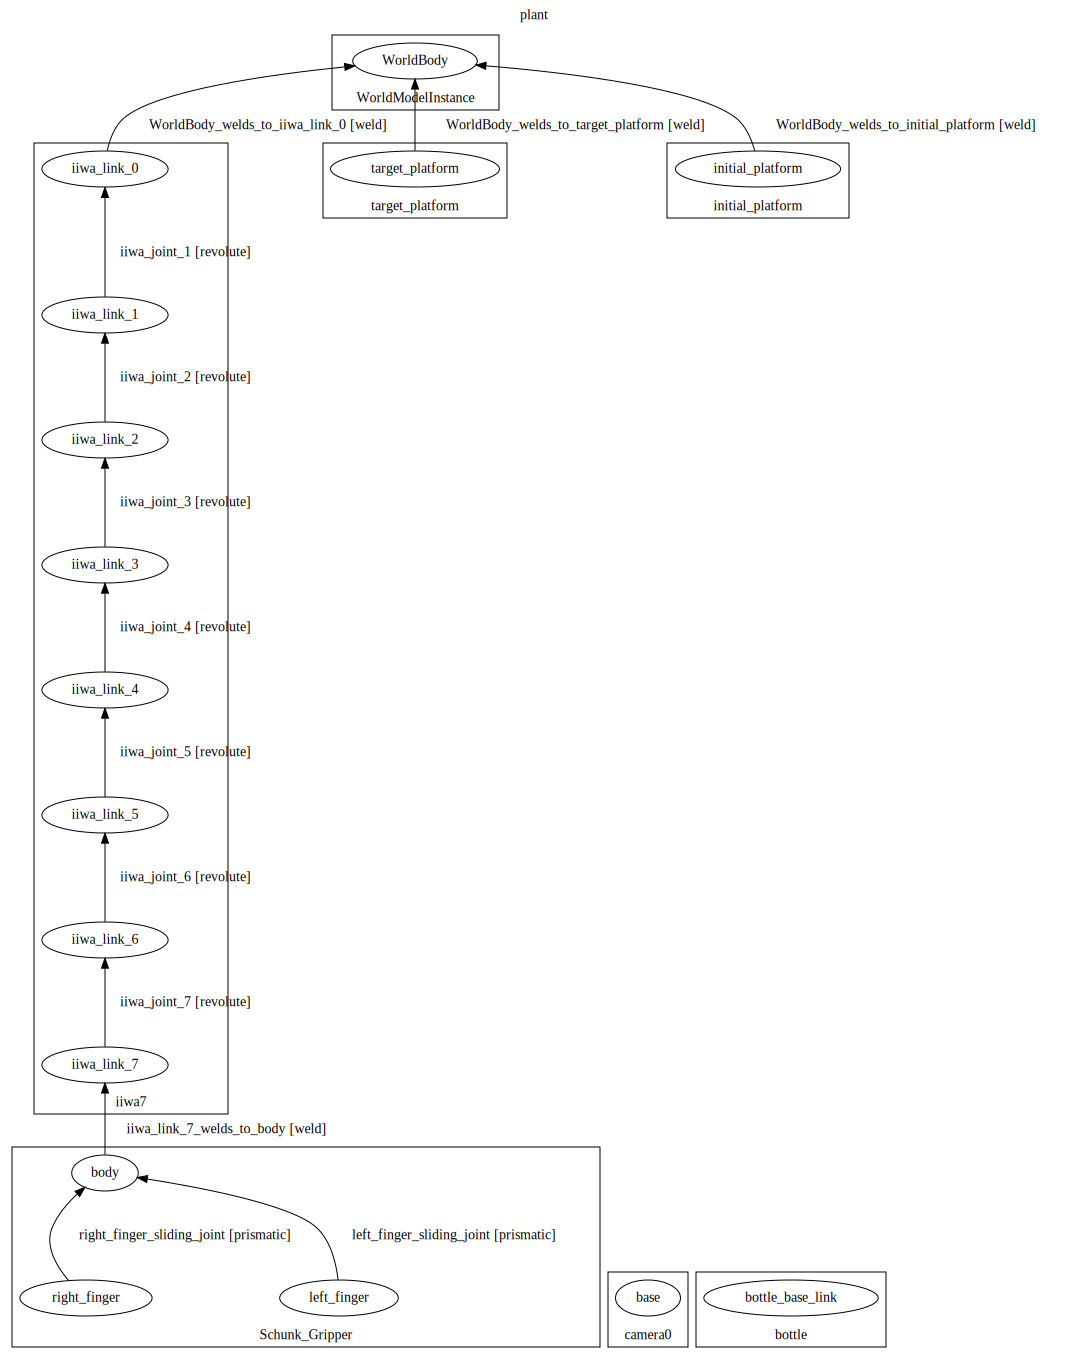

In [11]:
import pydot
from IPython.display import display, SVG
display(SVG(pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()))

# Optimize the release position and velocity

In [ ]:
T = 500 # number of timesteps
d = 12 # state dimension

def dynamics(x):
    dx = np.zeros_like(x)
    dx[0:3] = x[3:6] # velocity
    dx[5] = -9.81    # acceleration
    dx[6:9] = x[9:] # angular velocity
    return dx

prog = MathematicalProgram()
# create decision variables for the state and the timestep
state = prog.NewContinuousVariables(T + 1, d, 'state')
dt = prog.NewContinuousVariables(1, 'dt')

# bound the starting and ending positions
prog.AddLinearConstraint(eq(state[0,:3], np.array([1,0,0.5]))) # constrain initial position
prog.AddLinearConstraint(eq(state[-1,:3], np.array([3,0,0]))) # constrain final position
prog.AddLinearConstraint(eq(state[0, 6:9], np.zeros(3))) # constrain initial orientation
prog.AddLinearConstraint(eq(state[-1, 6:9], np.array([0,-2*np.pi-1e-3, 0]))) # constrain final orientation
# force it to be rotating backwards
# prog.AddBoundingBoxConstraint(np.array([0,-10,0]), np.array([0,-1,0]), state[0,9:]) # constrain intial rotational velocity

# Bound the timestep
prog.AddBoundingBoxConstraint(0.002, 0.05, dt[0])
# Do timestepping. Easy to do fixed timesteps with symplectic Euler
for t in range(T):
	prog.AddConstraint(eq(state[t+1], state[t] + dt[0]*dynamics(state[t])))


bottle_radius = 0.03
bottle_height_of_cg = 0.075
bottle_I_yy = 0.00105
bottle_mass = 0.5
sim_timestep = 0.002

angular_momentum = bottle_I_yy * state[0,10]
impact_torque = bottle_radius * bottle_mass * state[-1,5]
friction_torque = -bottle_height_of_cg * bottle_mass * state[-1, 3]
torque = impact_torque + friction_torque

prog.AddConstraint(angular_momentum == torque*sim_timestep)


result = Solve(prog)
assert(result.is_success()), "Optimization failed"
x0 = result.GetSolution(state)[0]
xT = result.GetSolution(state)[-1]
print(f'Release Velocity {x0[3:6]}')
print(f'Release Angular Velocity {x0[9:]}')
print(f'Timestep {result.GetSolution(dt)}')

In [ ]:
bottle_radius = 0.03
bottle_height_of_cg = 0.075
bottle_I_yy = 0.00105
bottle_mass = 0.5
sim_timestep = 0.002

angular_momentum = bottle_I_yy * x0[10]
impact_torque = bottle_radius * xT[5]
friction_torque = -bottle_height_of_cg * xT[3]
torque = impact_torque + friction_torque


print(angular_momentum,torque*sim_timestep)

In [ ]:
np.vstack([np.zeros(3), np.ones(3)]).T.shape

# Junk

Ok, I know that the manipulation station is supposed to wrap some functionality and give us a controller, but I find it very confusing because it hides what little documented functionality drake has... so here's an attempt to not use it

In [ ]:
# top level simulation environment
builder = pydrake.systems.framework.DiagramBuilder()
# the plant is the dynamics model. The scene graph is a tree storing relations
# between objects
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-2)
# the parser allows us to add models to the plant and scene graph
parser = Parser(plant, scene_graph)
# so let's add the bottle and the robot arm
iwaa_file_path = pydrake.common.FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf")
parser.AddModelFromFile(iwaa_file_path)
parser.AddModelFromString(bottle_sdf, "sdf") # need to specify filetype
# then we need to attach the base of the robot to the ground
# plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
# and for some reason when we're done we have to call
plant.Finalize()
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)

In [ ]:
from pydrake.all import eq, MathematicalProgram, Solve, Variable
from pydrake.all import LinearSystem, DirectTranscription
import math
import matplotlib.pyplot as plt

prog = MathematicalProgram()

dt = 0.01;
g = 9.81
N = 50
vx0 = 10
vy0 = 10
h = 3

A = np.eye(12)
A[0, 3] = 1
A[1, 4] = 1
A[2, 5] = 1
A[6, 9] = 1
A[7, 10] = 1
A[8, 11] = 1
B = dt*np.array([[0, 0, 0, 0, 0, -g, 0, 0, 0, 0, 0, 0]]).T
C = np.eye(12)
D = np.zeros((12,1))

sys = LinearSystem(A, B, C, D, dt)

prog = DirectTranscription(sys, sys.CreateDefaultContext(), N)
#prog.AddBoundingBoxConstraint(x0, x0, prog.initial_state())
#prog.AddBoundingBoxConstraint(xf, xf, prog.final_state())
#prog.AddConstraintToAllKnotPoints(prog.input()[0] == 1)
#prog.AddConstraintToAllKnotPoints(prog.input()[0] == 1)

initial_state_l = (0., 0., h, -vx0, 0, 0, 0., 0., 0, -vx0, -vy0, 0.)
initial_state_u = (0., 5., 0., vx0, 0, 100, 0., 0., 0, vx0, vy0, 0.)

prog.AddBoundingBoxConstraint(initial_state_l, initial_state_u, prog.initial_state())

final_state_l = (0., -5., 0., -vx0, -vy0, -100, 0., 0., -math.pi, 0., 0., 0.)
final_state_u = (0., 5., 0., vx0, vy0, 0, 0., 0., math.pi, 0., 0., 0.)

prog.AddBoundingBoxConstraint(final_state_l, final_state_u, prog.final_state())

#prog.AddConstraint(state[timesteps, :] == xf)
# Do timestepping. Easy to do fixed timesteps with symplectic Euler, but timesteps can be decision variables as well. 
#for t in range(timesteps + 1):
#	prog.AddConstraint(x[t+1,:] = dynamics(x[t,:]) * h)

result = Solve(prog)
x_sol = prog.ReconstructStateTrajectory(result)
assert(result.is_success()), "Optimization failed"


plt.figure()
x_values = x_sol.vector_values(x_sol.get_segment_times())

plt.plot(x_values[0,:1], x_values[1,:1])
plt.xlabel('q')
plt.ylabel('qdot')